# Epidemics on networks

On this lab we will consider an implementation of disease spreading over a network. We will start from SIS model and slightly modify it to SIR model.

## SIS model

Just to recall from the lecture how it looks like:<br\>
\begin{equation}
   \begin{cases}
   \cfrac{ds_i(t)}{dt} = -\beta s_i(t)\sum\limits_j A_{ij}x_j(t) + \gamma x_i(t)\\
   \cfrac{dx_i(t)}{dt} = \beta s_i(t)\sum\limits_j A_{ij}x_j(t) - \gamma x_i(t)
  \end{cases}
  \\
  x_i(t) + s_i(t) = 1
\end{equation}
where $x_i(t)$ and $s_i(t)$ are probabilities for a node $v_i$ to be infected or susceptable.

In [1]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
from numpy.linalg import eig
from scipy.integrate import odeint
%matplotlib inline

In [24]:
# Let's start from a complete graph
n = 50
G = nx.watts_strogatz_graph(n, 5, 0.4)

# Get adj. matrix
A = np.array(nx.adjacency_matrix(G).todense())

# Spreading\restoring coefficient
beta, gamma = 0.03, 0.2

# Time domain
t = np.arange(0,5,0.05)

# Initial state
idx = np.random.choice(range(n), 5)
i0 = np.zeros((n,))
i0[idx] = 1
# i0 = np.random.random_integers(0,1,[n,])
z0 = np.concatenate((1-i0,i0))

# System of differential equations..
def sis(z, t, A, n, beta, gamma):
    return np.concatenate((
        -beta * z[0:n] * A.dot(z[n:2*n]) + gamma * z[n:2*n],
         beta * z[0:n] * A.dot(z[n:2*n]) - gamma * z[n:2*n]))
        

# ..Solved
z = odeint(sis, z0, t, (A, n, beta, gamma))

In [3]:
# It's a bit messy, so let's see what we have got here
z.shape

(20, 100)

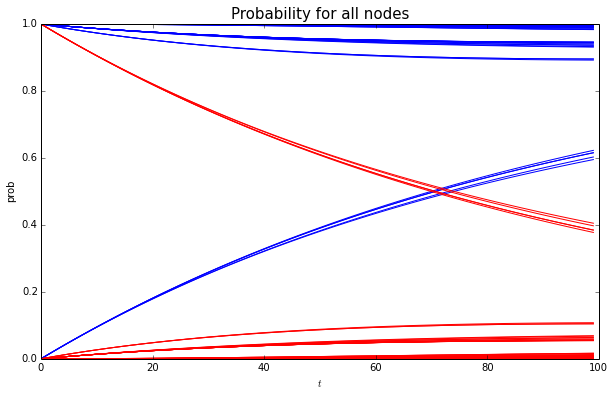

In [25]:
# Plot probs for some node
nId = 6
s = z[:,0:n]
x = z[:,n:2*n]


fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(s,color = 'blue')
ax.plot(x,color = 'red')
ax.set_xlabel('$t$')
ax.set_ylabel('prob')
ax.set_title('Probability for all nodes', fontsize = 15)

Hope that you remember that stuff about the correspondence between largest eigenvalue and $\frac{\gamma}{\beta}$ ratio:<br/>
* if $\lambda_1 > \frac{\gamma}{\beta}$ - GROWTH
* if $\lambda_1 < \frac{\gamma}{\beta}$ - NOPE <br/>
Check it

In [23]:
w,v = eig(A)
print max(w), gamma/beta

4.47087231 0.666666666667


### Task

1. Play with $\gamma$, $\beta$ parameters and try out SIS model for other graphs
2. Does it matter how many nodes are initially infected?

## SIR model

In SIR model healed population gain immunity to the infection
\begin{equation}
   \begin{cases}
   \cfrac{ds_i(t)}{dt} = -\beta s_i(t)\sum\limits_j A_{ij} x_j(t)\\
   \cfrac{dx_i(t)}{dt} = \beta s_i(t)\sum\limits_j A_{ij} x_j(t) - \gamma x_i(t)\\
   \cfrac{dr_i(t)}{dt} = \gamma x_i(t)
  \end{cases}
  \\
  x_i(t) + s_i(t) + r_i(t) = 1
\end{equation}

Adapt the code above to produce SIR model

In [36]:
# Let's start from a complete graph
n = 50
G = nx.barabasi_albert_graph(n, 5)

# Get adj. matrix
A = np.array(nx.adj_matrix(G))

# Spreading\restoring coefficient
beta, gamma = 0.3, 0.2

# Time domain
t = np.arange(0,5,0.05)

# Initial state
idx = np.random.choice(range(n), 30)
i0 = np.zeros((n,))
i0[idx] = 1
# i0 = np.random.random_integers(0,1,[n,])
z0 = np.concatenate((1-i0,i0,np.zeros((n,))))

# System of differential equations..
def sir(z, t, A, n, beta, gamma):
    return np.concatenate((
        -beta * z[0:n] * A.dot(z[n:2*n]),
         beta * z[0:n] * A.dot(z[n:2*n]) - gamma * z[n:2*n],
         gamma * z[n:2*n]
        ))
        

# ..Solved
z = odeint(sir, z0, t, (A, n, beta, gamma))

In [29]:
z.shape

(20, 150)

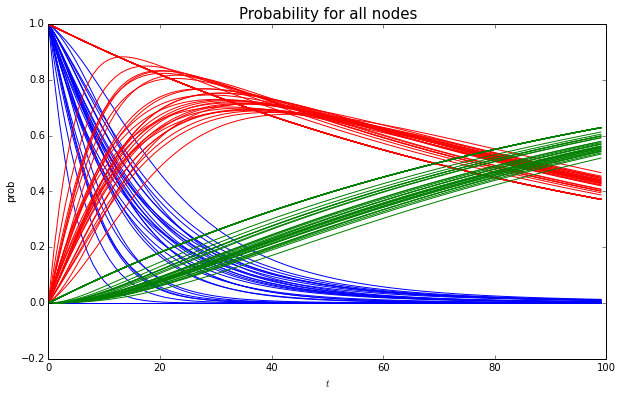

In [37]:
# Plot probs for some node
nId = 6
s = z[:,0:n]
x = z[:,n:2*n]
r = z[:,2*n:3*n]


fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(s,color = 'blue')
ax.plot(x,color = 'red')
ax.plot(r,color = 'green')
ax.set_xlabel('$t$')
ax.set_ylabel('prob')
ax.set_title('Probability for all nodes', fontsize = 15)

## Stochastic Modelling

The stuff that you will see below is kind of simulation model of infection spreading on graph. The description of the model is the following: <br/>

* The infection has some vital period, the node is diseased for that period
* At the end of this period node become susceptible without immunity system's reinforcement
* Each infected node can spread disease within its neigbours with a sertain probability

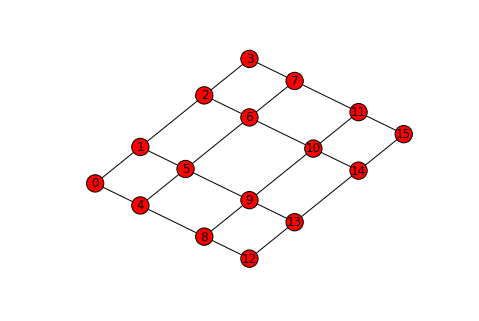

In [38]:
size = 4
# Create Grid Graph
G = nx.grid_2d_graph(size,size)

# Make node relabelling
f = {}
for v in G.nodes_iter():
    f[v] = v[0]*size+v[1]

G = nx.relabel_nodes(G, f)
nx.draw_spectral(G)

In [39]:
def simulSIS(A, timePeriod, modelParams):
    # init params
    initInfected = modelParams.get('initInfected', None)
    p = modelParams.get('probInfect', 0.5)
    upd = modelParams.get('updateInfection', True)
    maxRecTime = modelParams.get('t2Recover', 2)
    
    # init output
    n = A.shape[0]
    states = np.zeros([n, timePeriod+1]) # 1 = infected, 0 = susceptable
    recTime = np.zeros(n,)
    # set initially infected nodes
    if initInfected is None:
        initInfected = np.random.choice(range(n), n/2)
        states[initInfected,0] = 1
    else:
        states[initInfected,0] = 1
    recTime[initInfected] = maxRecTime + 1
    
    # Start simulation
    for t in xrange(1, timePeriod+1):
        recTime = np.maximum(recTime-1,0)
        states[recTime>0, t] = 1
        states[recTime==0, t] = 0
        
        curInf = np.nonzero(states[:,t])[0]
        states[curInf, t] = 1
        for i in curInf:
            #NN = np.setdiff1d(np.nonzero(A[i,])[0], curInf)
            NN = np.nonzero(A[i,])[0]
            infNN = NN[np.random.rand(len(NN))<p]
            states[infNN, t] = 1
            recTime[infNN] = maxRecTime + 1
            
    return states
    

In [57]:
# Running model

timePeriod = 11
modelParams = {}
modelParams['t2Recover'] = 3
modelParams['initInfected'] = None
modelParams['probInfect'] = 0.1
modelParams['updateInfection'] = True

A = np.array(nx.adj_matrix(G))

states = simulSIS(A, timePeriod, modelParams)

In [41]:
states

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  

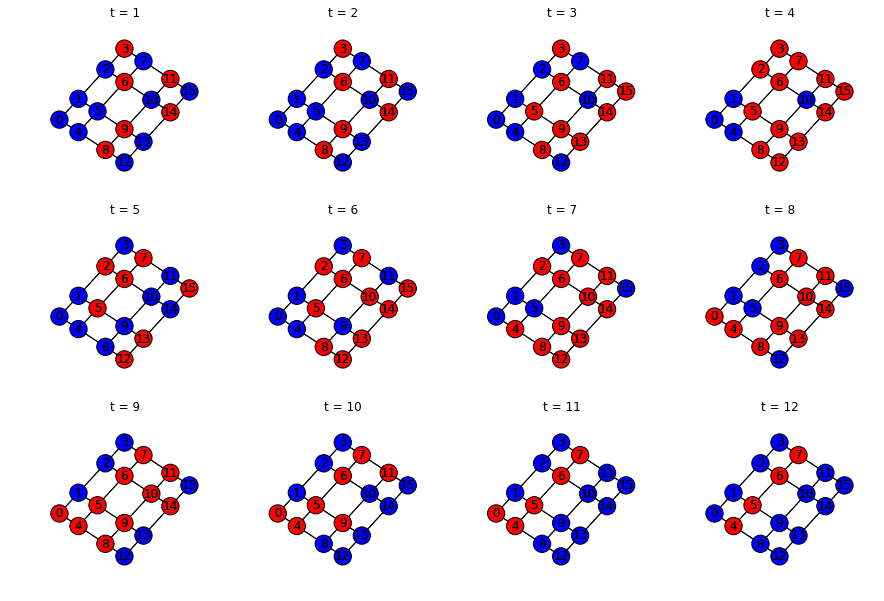

In [58]:
# Plotting inferction spread

pos = nx.spectral_layout(G)
fig = plt.figure(figsize=(15,10))
for t in xrange(0,timePeriod+1):
    plt.subplot(3,4,t+1)
    nx.draw_spectral(G,
        nodelist=np.nonzero(states[:,t])[0].tolist(),
        node_color = 'r')
    nx.draw_spectral(G,
        nodelist=np.nonzero(1-states[:,t])[0].tolist(),
        node_color = 'b')
    plt.title('t = {0}'.format(t+1))

## The branching process

In simple branchin process (tree of depth $h$ with $k$ leaths per each parent and probability $p$ to infect a neigbour) we are considerring $R_0=pk$ - the basic reproductive number of the infection. <br/>
* If $R_0 < 1$ infection will stop without reaching the bottom of the tree
* If $R_0 > 1$ infertion will corrupt all population

In [159]:
## Checking of branching branching process

G=nx.balanced_tree(3,7, create_using=nx.DiGraph())
sp = nx.shortest_path_length(G,0)

timePeriod = 10
modelParams = {}
modelParams['t2Recover'] = 1
modelParams['initInfected'] = [0]
modelParams['probInfect'] = 0.2
modelParams['updateInfection'] = False

A = np.array(nx.adj_matrix(G))

states = simulSIS(A, timePeriod, modelParams)
sum(states)

array([ 1.,  3.,  5.,  6.,  5.,  2.,  0.,  0.,  0.,  0.,  0.])